# <font color =blue> **Mobile Games: A/B Testing & Player Retention**

Data Source: https://www.kaggle.com/yufengsui/mobile-games-ab-testing

## Importing Libraries and Data

In [2]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Understanding the Data

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- `userid` - a unique number that identifies each player.
- `version` - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- `sum_gamerounds` - the number of game rounds played by the player during the first week after installation
- `retention_1` - did the player come back and play 1 day after installing?
- `retention_7` - did the player come back and play 7 days after installing?<br/>

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40

In [4]:
df.info()
#There are no missing values in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<font color =blue>**When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The number of players is roughly the same in the control and test group.**

In [8]:
df["userid"].nunique()

90189

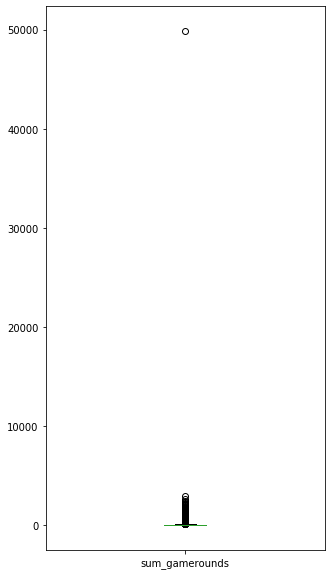

In [6]:
df['sum_gamerounds'].plot.box(figsize=(5,10))

In [9]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

In [11]:
main = plot_df[:100]
#subsetting only those who played from 0 to 199

In [18]:
main.sum()
#Nearly 86% have played upto level 100. 

77673

<font color =blue>**As we can see, 50% of players played fewer than 16 game rounds during the first week after installation, and 75% of players played fewer than 51 rounds.**
    
<font color =blue>**Nearly 4000 players did not even play a single round after installation.**
    
<font color =blue>**Another number worth attention is that more than 14,000 players played fewer than three rounds.**
    
<font color =blue>**It is important to understand why a large number of players quit the game at an early stage.**

Text(0.5, 0, '# Game rounds')

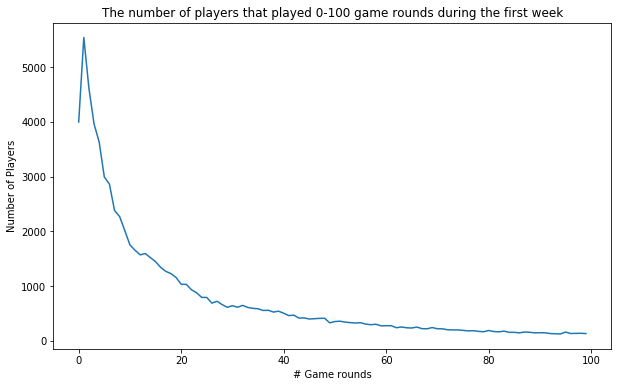

In [19]:
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

<font color =blue>**The distribution is highly skewed, with a long tail on the right. A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.**

## Comparing 1-day Retention 

<font color =blue> <p>In the plot above we can see that some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked. 
<p>A common metric in the video gaming industry for how fun and engaging a game is <strong>1-day retention: the percentage of players that comes back and plays the game one day after they have installed it.</strong>  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>

#### *Overall 1-day retention*

In [20]:
df['retention_1'].sum() / df['retention_1'].count() # When using .sum(), T/F will first be converted to 1/0.

# Equivalent to df['retention_1'].mean()
# Mean is calculated by summing the values and dividing by the total number of values.

0.4452095044850259

<font color =blue> **A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.**

#### *1-day retention for each AB-group*

In [21]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

<font color =blue> It appears that <strong>there was a slight decrease in 1-day retention when the gate was moved to level 40</strong> (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?
<p>There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

#### *Bootstrapping: Should we be confident in the difference?*

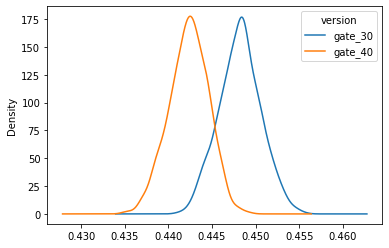

In [22]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

<font color =blue> These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. There seems to be some evidence of a difference, albeit small. Let's plot the % difference to have a closer look.

Probability that 1-day retention is greater when the gate is at level 30: 0.957


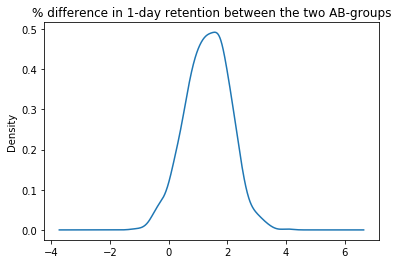

In [23]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

<font color =blue>  **From this chart, we can see that the most likely % difference is around 1% - 2%, and that <strong>96% of the distribution is above 0%, in favor of a gate at level 30.** </strong>

## Comparing 7-day Retention  <a name= '5'></a>
<font color =blue>  The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. <p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention.

In [24]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

<font color =blue>   **Insights:**
<ul>
    <li><strong>Like with 1-day retention, 7-day retention is slightly lower when the gate is at level 40</strong> (18.2%) than when the gate is at level 30 (19.0%). 
    <li><strong>This difference is also larger than for 1-day retention</strong>, presumably because more players have had time to hit the first gate. 
    <li> <strong>The overall 7-day retention is lower than the overall 1-day retention</strong>; fewer people play a game a week after installing than a day after installing.
</ul>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

Probability that 7-day retention is greater when the gate is at level 30: 0.998


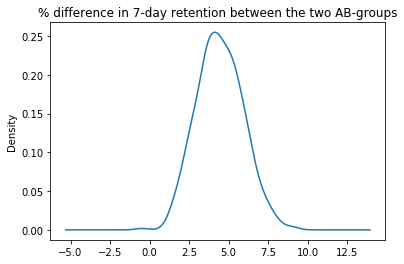

In [25]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

## Conclusion

<font color =blue>   <p>The bootstrap result tells us that <strong>there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.</strong> The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. 
<p>There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>


<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. 
<p>In short, <strong>hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously.</strong> By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But <strong>when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </strong></p>